# ROC Analysis, Response/Profit Curves, and Decision Making 


"*All models are wrong, but some are useful.*" — George Box

***

### Data and Modeling
In this lab session, we'll use the data set that was introduced in the Red Cross case study. As discussed in the case study, the target variables is `class` and is equal to one if the person donated blood and zero otherwise.

In [1]:
import pandas as pd

# Load the data
df = pd.read_csv("mailing.csv")
# Let's take a look at the data
df.head()

,Income,Firstdate,Lastdate,Amount,rfaf2,rfaa2,pepstrfl,glast,gavr,class
0,3,9409,9509,0.06,1,G,0,50,30.00,0
1,2,9201,9602,0.16,4,G,X,20,20.55,1
2,0,9510,9603,0.20,4,E,0,5,8.75,0
3,6,9409,9603,0.13,2,G,0,25,22.50,0
4,0,9310,9511,0.10,1,G,0,25,12.50,0


Some fields are **categorical** (text) instead of typical **numerical** fields, so we will transform those into dummy variables and split the data into training and test.

In [2]:
from sklearn.model_selection import train_test_split

y = df['class']
# Use all columns except the last one (which is the target) as features. 
X = df.iloc[:, :-1]
# Transform non-numeric variables into dummies.
X = pd.get_dummies(X, drop_first=False)
# Split the data into training and test.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

As an example, suppose we want to compare a decision tree model and a logistic regression model with the parameters specified below. 

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Parameters for the logistic regression model
logistic_model = LogisticRegression(solver='liblinear', C=1)
# Parameters for the decision tree
tree_model = DecisionTreeClassifier(criterion="entropy", min_samples_leaf=250, random_state=42)

## ROC Analysis and AUC

One useful approach to assess model performance is to estimate the expected value of the model's decisions. However, there are many situations in which the benefits and costs associated with each decision are not readily available. 

In those cases, ROC curves are a good alternative because they measure predictive performance in terms of the models' ability to rank (score) positive observations above negative observations, which doesn't require any knowledge about benefits and costs.

Fortunately, doing this in sklearn is relatively straightforward, as shown below.

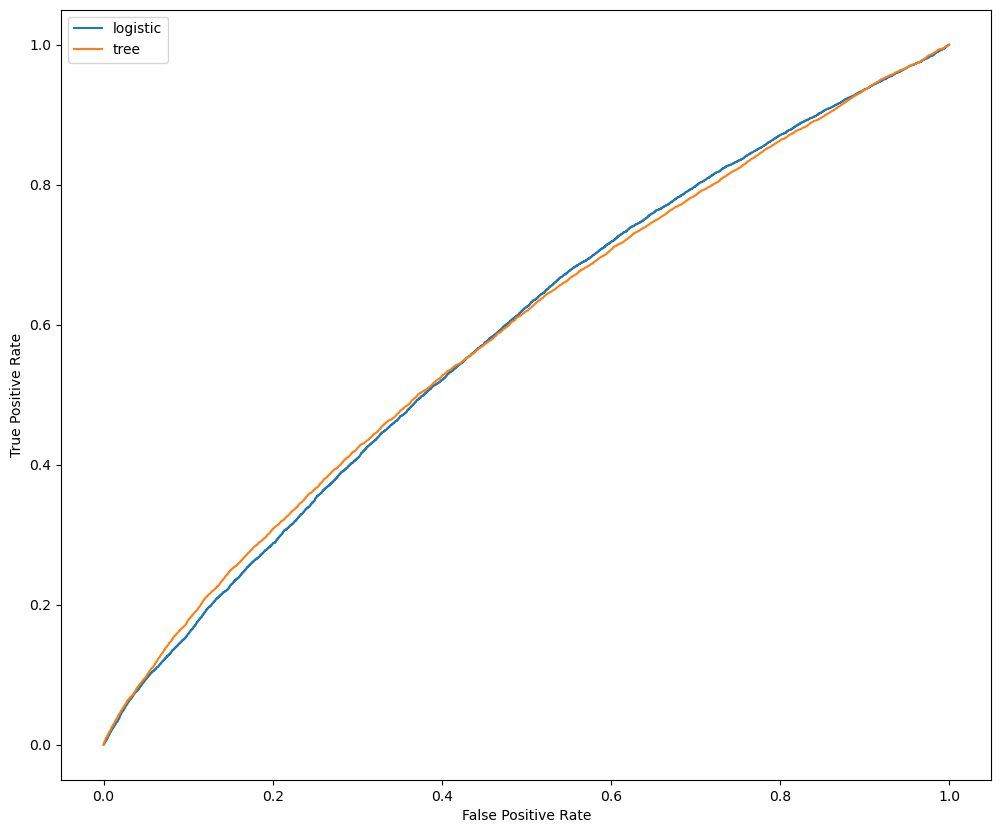

In [4]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
%matplotlib inline

# Make out-of-sample predictions for both models (as shown in the previous lab session)
# Note that I chose 'predict_proba' (which gives probabilities) for the method parameter.
# This is importat because by default cross_val_predict assumes you want to use the 'predict' method 
logistic_preds = cross_val_predict(logistic_model, X_train, y_train, cv=10, method="predict_proba")[:, 1]
tree_preds = cross_val_predict(tree_model, X_train, y_train, cv=10, method="predict_proba")[:, 1]

# Get false positive and true positives for each model
logistic_fpr, logistic_tpr, thresholds = roc_curve(y_train, logistic_preds)
tree_fpr, tree_tpr, thresholds = roc_curve(y_train, tree_preds)

# Plot the ROC curves
plt.figure(figsize=(12, 10))
plt.plot(logistic_fpr, logistic_tpr, label="logistic")
plt.plot(tree_fpr, tree_tpr, label="tree")
plt.legend()
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

As discussed in Chapter 8, the curves represent the false positive rates and the true positive rates for all possible thresholds, and the closer the curves are to the upper left corner, the better their predictive performance. 

Interestingly, the tree ROC curve is above the logistic ROC curve on the left side of the chart, whereas the opposite is the case on the right side of the chart. This implies that the tree is a better model when a low false positive rate is preferable, whereas the logistic model is better when a high true positive rate is preferable. So, even when benefits and costs are not available, the ROC curves are helpful to determine which model is better depending on the application.

In some cases, however, it is useful to have single-value measure to summarize the predictive performance of algorithms. In such cases, one can compute the Area Under the Curves (AUCs) of the models being compared. This is also straightforward to do with sklearn. 

In [5]:
from sklearn.metrics import auc

# Get AUC
logistic_auc = auc(logistic_fpr, logistic_tpr)
tree_auc = auc(tree_fpr, tree_tpr)

# Print results
pd.DataFrame({"Model":['Logistic Regression', 'Decision Tree'], "AUC":[logistic_auc, tree_auc]})

,Model,AUC
0,Logistic Regression,0.584284
1,Decision Tree,0.585662


One can also use AUC as the performance measure of a grid search by including the parameter `scoring="roc_auc"`.

In [6]:
from sklearn.model_selection import GridSearchCV

# Search for best complexity when optimizing for AUC
grid = {"min_samples_leaf":[250, 500, 1000, 2000, 4000]}
searcher = GridSearchCV(tree_model, grid, cv=10, scoring="roc_auc")
searcher.fit(X_train, y_train)

# Plot result
print(f"Best tree depth: {searcher.best_params_}")
print(f"Best AUC: {searcher.best_score_}")

Best tree depth: {'min_samples_leaf': 4000}
Best AUC: 0.6014731547302418


## Response curves

One disadvantage of ROC curves is that their interpretation may not be entirely intuitive to business stakeholders. Thus, in many applications, the cumulative response curve (also known as cumulative gains curve) is more appropriate. Cumulative response curves have the same y-axis as the ROC curves (percentages of positives identified by the model), but the x-axis corresponds to the percentage of the population that is targeted (i.e., the percentage of observations that are predicted to be positive).

Unfortunately, sklearn does not have a function to plot these curves, but it's not too hard to code a custom function to do so (as shown below). Here's also another [library](https://scikit-plot.readthedocs.io/en/stable/metrics.html) that does have a function to plot such curves (in case you want to check it out).

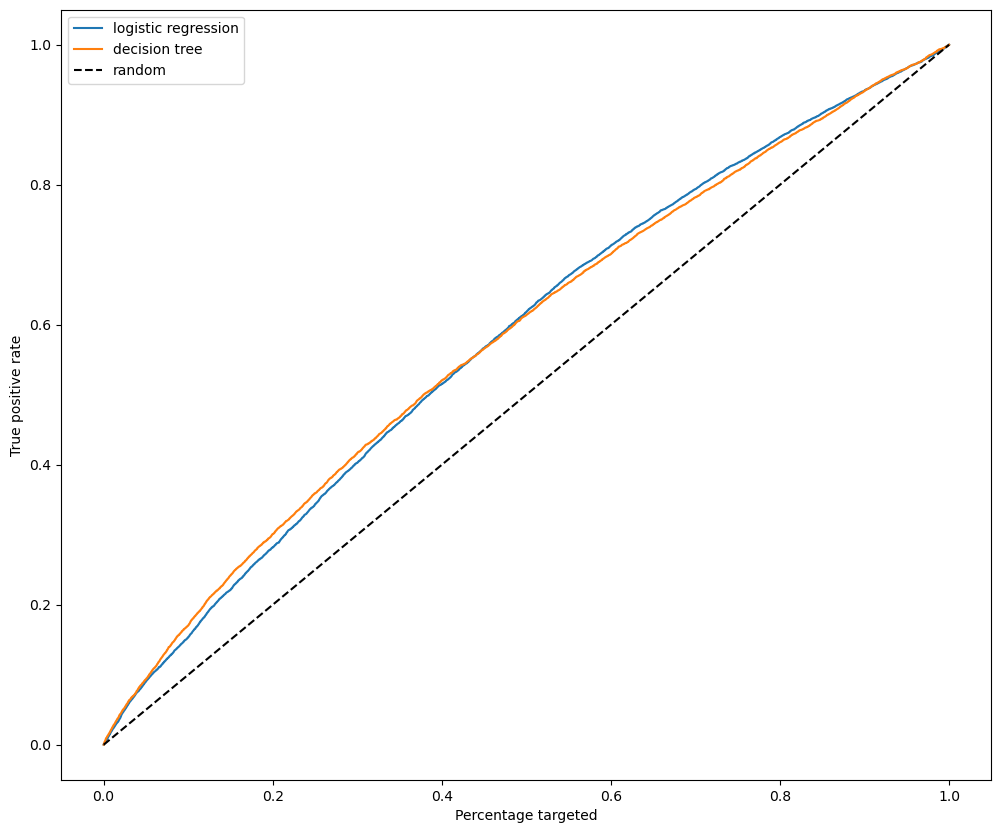

In [7]:
import numpy as np

# Function to plot response curves
def plot_response_curve(y_true, y_pred, yaxis_as_percentage=True):
    data_size = y_true.shape[0]
    # Get descending ranking according to predictions
    pred_rank = np.argsort(-y_pred)
    # Get cumulative sum of responses
    responded = y_true.values[pred_rank].cumsum()
    if yaxis_as_percentage:
        responded = responded/responded[-1]
    # Get percentage targeted
    targeted = np.arange(1, data_size+1) / y_true.shape[0]
    # Plot curve
    plt.plot(targeted, responded)
    
plt.figure(figsize=(12, 10))
plot_response_curve(y_train, logistic_preds)
plot_response_curve(y_train, tree_preds)
plt.plot([0, 1], [0, 1], "--", color="black")
plt.legend(["logistic regression", "decision tree", "random"], loc="upper left")
plt.ylabel("True positive rate")
plt.xlabel("Percentage targeted")
plt.show()

This chart shows a similar result to the ROC analysis: if we can only target a small number of people (a small false positive rate is preferable), the tree works better. On the other hand, if we can target a large number of people (a large true positive rate is preferable), the logistic regression model works better.

Alternatively, we may also adjust the cumulative response curves to plot profit curves, which represent the cumulative profits depending on how many individuals are targeted. Using the same benefits and costs discussed in the Red Cross case study, suppose that the net benefit of targeting a positive instance is \\$85 and that the net benefit of targeting a negative is -\\$5. Then a profit curve would look as follows.

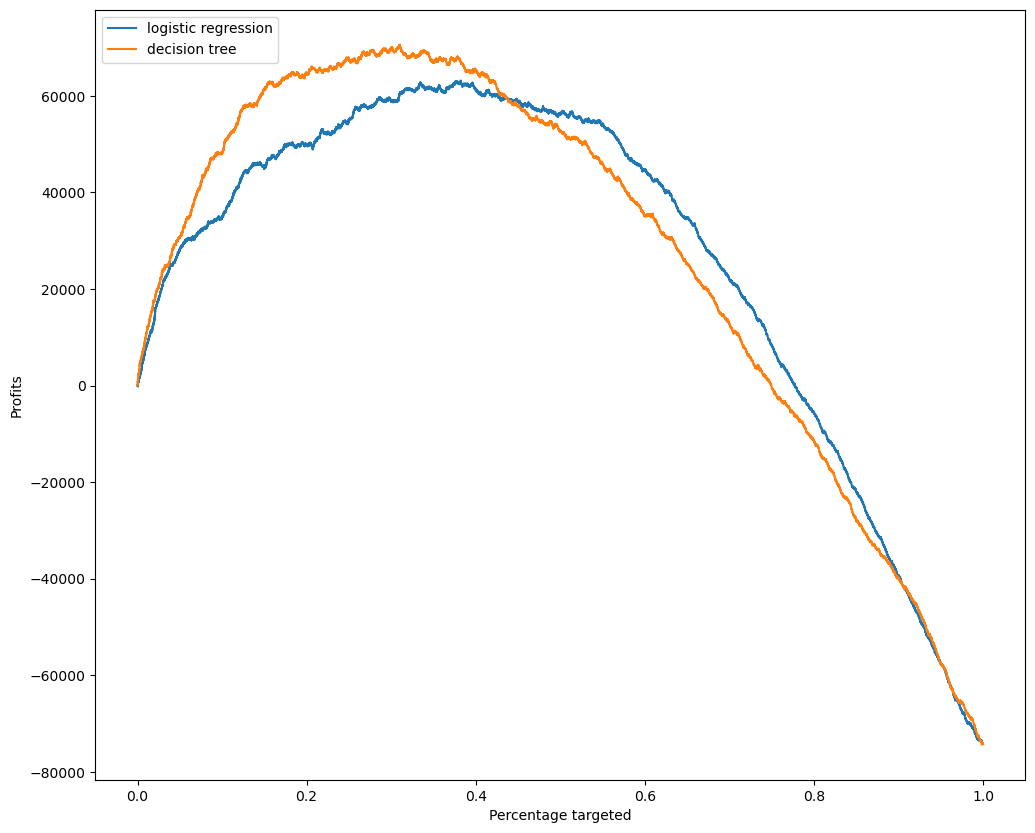

In [8]:
# Calculate profits per individual
profits_train = y_train * 90 -5

# Plot profit curves
plt.figure(figsize=(12, 10))
plot_response_curve(profits_train, logistic_preds, yaxis_as_percentage=False)
plot_response_curve(profits_train, tree_preds, yaxis_as_percentage=False)
plt.legend(["logistic regression", "decision tree", "random"], loc="upper left")
plt.ylabel("Profits")
plt.xlabel("Percentage targeted")
plt.show()

This chart shows that profits are maximized when a relatively small percentage of individuals are targeted (\~30\%), and as a result the tree model is better than the logistic regression model for the purposes of maximizing profit. 

## Decision Making

Assuming we do have access to benefits and costs, there are two ways in which one can determine the best threshold for decision making. 

The first approach is to determine the threshold analytically. According to the expected value framework, we should target someone if the expected benefit of targeting is larger than the expected benefit of not targeting. Therefore, in this example, we should target someone if $P*90 - 5> 0$ (where $P$ is the probability that the individual donates blood), so we should target if: $P>\frac{5}{90}$.

The second approach is to determine the threshold empirically by finding the threshold that maximizes profits according to the data. This is equivalent to plotting the profit curve and finding the percentile (threshold) where profits are maximized. This approach can be particularly useful when one is concerned about the model's ability to accurately estimate probabilities.

Both of the approaches are illustrated below.

In [9]:
###### ANLAYTICAL APPROACH
a_threshold = 5/90
# Make decisions with analytical threshold
a_decisions_val = tree_preds >= a_threshold
a_avg_profits = round((profits_train * a_decisions_val).mean(), 2)
print(f"Analytical threshold: {a_threshold}.")
print(f"Avg. profit per individual in validation set: ${a_avg_profits}\n")

###### EMPIRICAL APPROACH
# Get descending ranking according to predictions
pred_rank = np.argsort(-tree_preds)
# Get cumulative sum of profits
responded = profits_train.values[pred_rank].cumsum()
# Find position of optimal profits
best_ix = responded.argmax()
# Use probability of the observation in that position as threshold
e_threshold = tree_preds[pred_rank][best_ix]
# Make decisions with empirical threshold
e_decisions_val = tree_preds > e_threshold
e_avg_profits = round((profits_train * e_decisions_val).mean(), 2)
print(f"Empirical threshold: {e_threshold}")
print(f"Avg. profit per individual in validation set: ${e_avg_profits}")

Analytical threshold: 0.05555555555555555.
Avg. profit per individual in validation set: $0.39

Empirical threshold: 0.06088992974238876
Avg. profit per individual in validation set: $0.41


By definition, the empirical approach will always perform better than the analytical approach in the validation set. However, if you decide to use the empirical approach to make decisions, you should evaluate the impact of the selected threshold (and model) in the test set.  

In [10]:
# Make predictions and decisions in the test set
tree_model.fit(X_train, y_train)
test_preds = tree_model.predict_proba(X_test)[:, 1]
test_decisions = test_preds > e_threshold
# Evaluate the results of these decisions
profits_test = y_test * 90 - 5
test_avg_profits = round((profits_test * test_decisions).mean(), 2)
print(f"Avg. profit per individual in test set: ${test_avg_profits}")

Avg. profit per individual in test set: $0.48


Surprisingly, the results on the test set are even better than those on the validation set! While this is unusual, it can happen for two main reasons: 
* The test set may contain particularly "profitable" instances purely due to random variation. 
* The model evaluated on the test set was trained with more data than the one evaluated through cross-validation. As a result, performance may improve simply because of the increased training data.